## Pràctica 8


In [7]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs
import simpy

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))
    
qq = "\quad "

<>:25: SyntaxWarning: invalid escape sequence '\q'
<>:25: SyntaxWarning: invalid escape sequence '\q'
/tmp/ipykernel_15865/2011735719.py:25: SyntaxWarning: invalid escape sequence '\q'
  qq = "\quad "


### Exercici 1
- A una cabina experimental es genera ozó, que és un gas tòxic que volem extreure.
- Hem modelitzat l'extracció d'ozó de la següent manera:
$$x'  = -x \cdot Q/V + O \cdot R $$

on $x$ representa la concentració del gas, $Q$ representa el flux d'extracció d'aire, $V$ és el volum de l'habitació, $O$ és la concentració d'oxigen a l'aire i $R$ és el ritme de generació d'ozó.

Els valors mesurats dels paràmetres són els següents:
- La generació d'ozó es produeix a un ritme d'una molècula d'ozó per cada $(3.7 \pm 0.1) \times 10^9$ molècules d'oxigen per segon.
- La concentració d'oxigen a l'aire és de $20.9476 \pm 0.0005 \%$
- La cabina experimental té un volum de $125.4 \pm 0.8 \, m^3$


#### Dades
- Per validar el model hem fet unes proves irradiant un volum d'aire amb un extractor.
    - Volum d'aire $1.0000 \pm 1\times10^{-4} m^3$
    - Cabal d'aire de l'extractor $1.0 \pm 0.1 \,l/s$
    - La precisió de les mesures de concentració és de $1\times10^{-3}$ ppm

Index(['t (s)', 'Concentració (ppm)'], dtype='object')


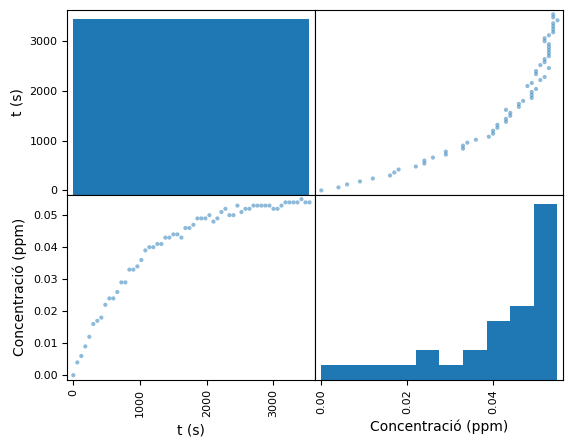

In [8]:
# Dades
data = pd.read_csv("https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/data/ozo.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

- Fes la validació del model i una anàlisi crítica considerant que l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm

Per trobar $R$:
- $\frac{dx}{dt} = \frac{QX}{V} - OR$
- $[O] = \frac{M_O}{M_T}$
- $[X] = \frac{M_Z}{M_T}$
- $[R] = \frac{X}{T}\frac{M_O}{M_T} = \frac{1}{t}\frac{M_Z}{M_T}\frac{M_T}{M_O} = \frac{1}{t}\frac{M_Z}{M_O}$
  - Com que ens diu "generació d'ozó ($R$) es produeix a **un ritme d'una molècula d'ozó per cada ... molècules d'oxigen per segon**, doncs ha de ser $1/R$

In [9]:
# Variables per defecte inicialitzades positiu/negatiu i poden ser 0
from sympy.abc import t, Q, V, O, R
# Alternativament Q = Symbol('Q', real=True)

# Si sé certes constraints sobre les variables, les puc definir jo més exactament
# Q = sp.Symbol('Q', nonzero=True, positive=True) # Per exemple, positiou i no zero

# Creem la x com a funció del temps
x = sp.Function('x')(t) # x(t), la concentració serà funció del temps t
# Diferencial d'x respecte al temps
dx = sp.diff(x, t) # x prima que ens servirà per a definir l'equació diferencial, usant x(t)

# Definim la equació diferencial que se'ns dona a l'enuncialt
fx = -x*Q/V + O*R # RHS de l'equació diferencial, al que equival la taxa de canvi
eq = sp.Eq(dx, fx) # Muntem l'equació diferencial, igualant la derivada a la funció de taxa de canvi

# Definim la condició inicial
ics = {x.subs(t, 0): 0} # Concentració inicial 0

# Resolem l'equació diferencial, per a "x", usant les condicions inicials
sol = sp.dsolve(eq, x, ics=ics) # resolem l'equació diferencial amb les condicions inicials per x(t)
show("solution:  ", sol)

xt = sol.rhs # El valor x en funció del temps t
show(xt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Anem a estudiar els valors de les dades que se'ns donen:
Definint $M_O$: Nombre mol·lècules OXÍGEN, $M_Z$: Nombre mol·lècules OZÓ i $M_T$: Nombre mol·lècules totals

- $x$: concentració del gas: $\frac{M_Z}{M_T}$
- $Q$: flux d'extracció d'aire: $\frac{m³}{s}$
- $V$: volum habitació: $m³$
- $O$: concentració d'oxigen a l'aire: $\frac{M_O}{M_T}$
- $R$: ritme generació ozó: Ara s'estudiarà

Mirant unitats expressió, tenim
- $x' = \frac{M_Z}{M_T · t}$
- $\frac{-x · Q}{V} = \frac{M_Z}{M_T}·\frac{m³}{s}·\frac{1}{m³} = \frac{M_Z}{M_T·s}$
- ...

In [10]:
# Defimim el valor de les variables que se'ns dona a l'enunciat
valors = {Q: 1.0*1e-3, 
          V: 1.0000,
          O: 20.9476/100,
          R: 1/(3.7*1e9)}

xt.subs(valors)

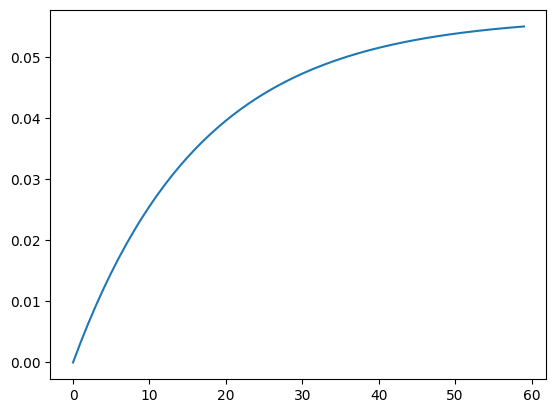

In [11]:
# Com que se'ns diu "partícules per milió", convertim la sortida a ello
ppm = 1e6
# Lambdify indicant que donarem valors numèrics a les variables, i indiquem que volem que ens quedi en funció de t, per tant substituïm per diferents valors de t
fxt = sp.lambdify(t, xt.subs(valors))

# Obtenim els temps de la taula de dades
times = data['t (s)']

# Calculem els valors de la funció per a cada temps, escalant la sortida a ppm
dp = fxt(times) * ppm

l = plt.plot(dp)


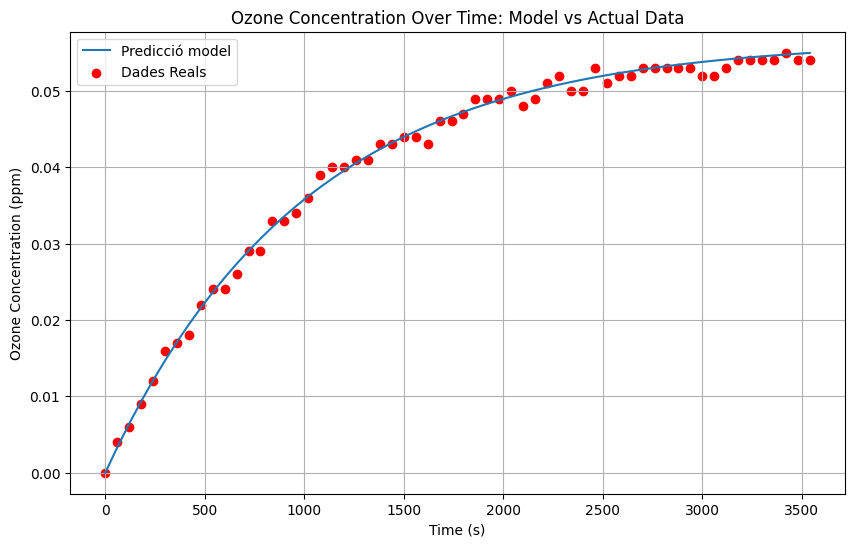

In [12]:
# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, dp, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)

Discrepànica: E = S - D

Incertesa dades nV = $\sqrt{U_s^2 + U_d^2}$

Confidence value $t=3$

In [13]:
discrepancies = data['Concentració (ppm)'] - dp

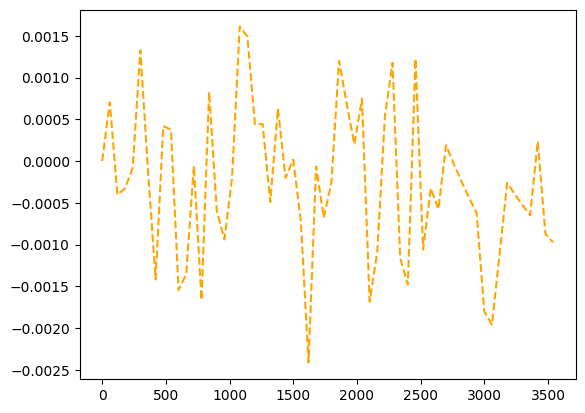

In [15]:
plt.plot(times, discrepancies, label='Discrepancies', color='orange', linestyle='--')

Mean discrepancy: -0.00027158948741160145


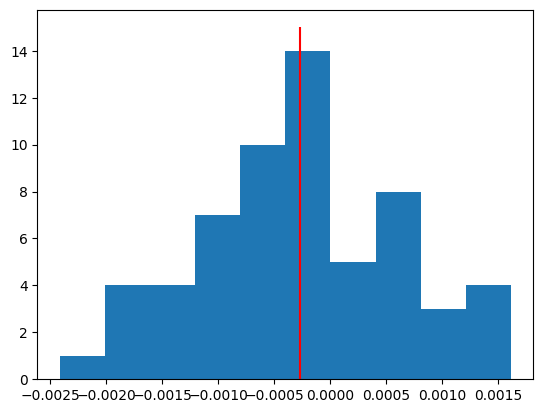

In [14]:
mean_discrepancy = np.mean(discrepancies)
plt.hist(discrepancies)
plt.vlines(mean_discrepancy, color='red', label='Mean Discrepancy', ymin=0, ymax=15)
print("Mean discrepancy:", mean_discrepancy)

Per a calcular els coeficients de discrepància usem l'equació:

$$c_i=\frac{x_i}{r}\frac{\partial r}{\partial x_i}$$

In [21]:
# si les dades són indirectes, hem de posar també l'incertesa que tenim de les dades...? 
# Com que només és amb les dades, només ens serveix per a trobar la incertesa mitjana, no els coeficients de sensitivitat
# Per a trobar-los correctament, fem el següent: ------------- exemple transistòmetre

# Per a cada una de les variables del nostre model, calculem el seu coeficient de sensitivitat
# !!!!! Ho fem amb la EQUACIÓ SOLUCIÓ
Coef_Q = Q / xt * sp.diff(xt, Q)
Coef_V = V / xt * sp.diff(xt, V)
Coef_O = O / xt * sp.diff(xt, O)
Coef_R = R / xt * sp.diff(xt, R)

In [22]:
show(Coef_Q, qq, Coef_V, qq, Coef_O, qq, Coef_R)

<IPython.core.display.Math object>

Ara, podem passar a calcular l'incertesa relativa de cada un d'aquests paràmetres, fent servir que:

$$I\_x_i = c_i x_i$$

In [36]:
Q_val = 1.0 * 1e-3
Q_unc = 0.1 * 1e-3
Q_rel_unc = Q_unc / Q_val

V_val = 125.4
V_unc = 0.8
V_rel_unc = V_unc / V_val

O_val = 20.9476 / 100
O_unc = (0.0005 / 100)
O_rel_unc = O_unc / O_val

R_val = 1 / (3.7 * 1e9)
R_unc = 0.1 / (3.7 * 1e9)
R_rel_unc = R_unc / R_val

Total_rel_unc= np.sqrt(Q_rel_unc**2 + V_rel_unc**2 + O_rel_unc**2 + R_rel_unc**2)
print("Total relative uncertainty:", Total_rel_unc)

Total relative uncertainty: 0.1415651781995735


In [37]:
#     = Coef_paràmetre * incertesa relativa
Cur_Q = Coef_Q * Q_rel_unc
Cur_V = Coef_V * V_rel_unc
Cur_O = Coef_O * O_rel_unc
Cur_R = Coef_R * R_rel_unc

urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R**2
show("urXt^2_C=", urXt2)

<IPython.core.display.Math object>

Recordem que incertesa de la discrepància =$ \sqrt{incertesa\_simulacio^2+incertesa\_dades^2} $

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in divide
  return sqrt(2.5e-11*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 7.3046018991965e-22*(209.476 - 209.476*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 4.06991089438836e-5*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 1.0e-8*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2)


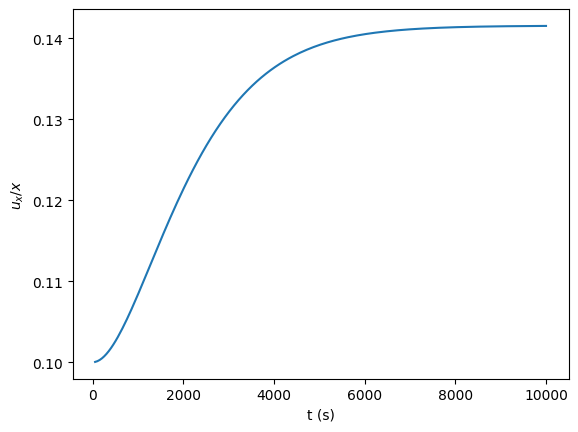

In [38]:
times = np.linspace(0, 10000, 200) #data['t (s)']

furC = sp.lambdify(t, sp.sqrt(urXt2).subs(valors))

urc = furC(times)

plt.plot(times, urc)
# plt.hlines(0.02, color='red', label='Uncertainty Threshold', xmin=0, xmax=1000)
plt.xlabel('t (s)')
plt.ylabel('$u_x/x$')
plt.show()

Notem que l'incertesa evoluciona i s'estabilitza al voltant de $0.14$, $14$%.

L'enunciat ens diu: *l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm*. Això ens està demanant tenir una incertesa relativa sobre $x(t)$ del $\frac{0.1 ppm}{5 ppm} = 0.02$, $2$%.

La incertesa estàndard relativa representa una desviació estàndard: $\sigma = \frac{u(x)}{x}$

Hem de trobar un nivell de confiança del 95% en quin interval es pot trobar la incertesa de la concentració d'ozó. Per passar la desviació estàndard a un interval de confiança del 95%, cal multiplicar pel factor de cobertura estadística, aprozimem que $z(95\%) = 2$

Per tant, busquem que: $x \pm 2u(x) = 5 \pm 0.1$ ppm
- $2\frac{u(x)}{x} \le 0.02 \to \frac{u(x)}{x} \le 0.01$

In [39]:
# Mirem si a algun instant de temps es cumpleix
temps_acceptable = times[urc <= 0.01]
print("Temps acceptables:", temps_acceptable)

Temps acceptables: []


Veiem per tant que el model actual amb l'incertesa associada no compleix el que es vol. S'haurà d'ajustar les incerteses dels paràmetres per a obtenir una incertesa total menor.

In [40]:
# Veiem quin és el valor de la incertesa s'estabilitza. Triem (t=8000 perq aprox ja s'ha estabilitzat)
temps_estabilitzat = 8000
Cur_Q_val = Cur_Q.subs({t: temps_estabilitzat, **valors}).evalf()
Cur_V_val = Cur_V.subs({t: temps_estabilitzat, **valors}).evalf()
Cur_O_val = Cur_O.subs({t: temps_estabilitzat, **valors}).evalf()
Cur_R_val = Cur_R.subs({t: temps_estabilitzat, **valors}).evalf()

print(f"Q: {Cur_Q_val}, V: {Cur_V_val}, O: {Cur_O_val}, R: {Cur_R_val}")

Q: -0.0997315398393270, V: 0.00636245868193474, O: 0.0000238690828543604, R: 0.100000000000000


<lambdifygenerated-10>:2: RuntimeWarning: invalid value encountered in divide
  return 0.0001*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-11>:2: RuntimeWarning: invalid value encountered in divide
  return 0.00637958532695375*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in divide
  return 5.0e-6*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-13>:2: RuntimeWarning: invalid value encountered in divide
  return 2.7027027027027e-11*(209.476 - 209.476*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))


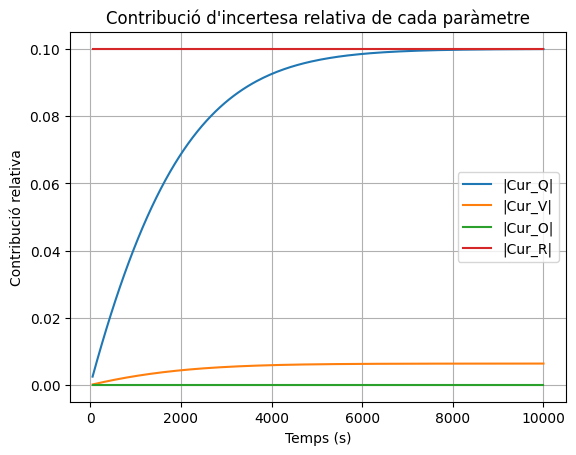

In [41]:
def contribucio_parametres(Cur_q, Cur_v, Cur_o, Cur_r):
    times = np.linspace(0, 10000, 200) 
    
    fur_CurQ = sp.lambdify(t, Cur_q.subs(valors))
    fur_CurV = sp.lambdify(t, Cur_v.subs(valors))
    fur_CurO = sp.lambdify(t, Cur_o.subs(valors))
    fur_CurR = sp.lambdify(t, Cur_r.subs(valors))

    CurQ_vals = fur_CurQ(times)
    CurV_vals = fur_CurV(times)
    CurO_vals = fur_CurO(times)
    CurR_vals = fur_CurR(times)

    plt.plot(times, np.abs(CurQ_vals), label='|Cur_Q|')
    plt.plot(times, np.abs(CurV_vals), label='|Cur_V|')
    plt.plot(times, np.abs(CurO_vals), label='|Cur_O|')
    plt.plot(times, np.abs(CurR_vals), label='|Cur_R|')

    plt.legend()
    plt.title("Contribució d'incertesa relativa de cada paràmetre")
    plt.xlabel('Temps (s)')
    plt.ylabel('Contribució relativa')
    plt.grid(True)
    plt.show()

contribucio_parametres(Cur_Q, Cur_V, Cur_O, Cur_R)

Nova incertesa relativa total: 0.1007010411002637
Antiga incertesa relativa total: 0.1415651781995735


<IPython.core.display.Math object>

<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in divide
  return sqrt(2.5e-11*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 7.3046018991965e-26*(209.476 - 209.476*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 4.06991089438836e-5*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 1.0e-8*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2)


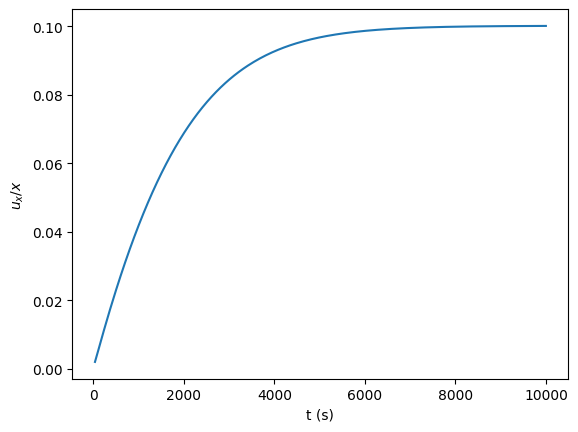

In [42]:
# reduim la incertesa de R entre 10 (s'ha provat entre 2 i 4 i se seguia superant el límit)
reduir = 10

R_unc_new = R_unc / reduir
R_rel_unc_new = R_unc_new / R_val

# Recalculem la incertesa relativa total
incertesa_relativa_total_new = np.sqrt(R_rel_unc_new**2 + O_rel_unc**2 + V_rel_unc**2 + Q_rel_unc**2)
print(f"Nova incertesa relativa total: {incertesa_relativa_total_new}")
print(f"Antiga incertesa relativa total: {Total_rel_unc}")

Cur_R_new = Cur_R * R_rel_unc_new

urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R_new**2
show("urXt^2_C=", urXt2)
times = np.linspace(0, 10000, 300) #data['t (s)']
furC = sp.lambdify(t, sp.sqrt(urXt2).subs(valors))

urc = furC(times)

plt.plot(times, urc)
# plt.hlines(0.02, color='red', label='Uncertainty Threshold', xmin=0, xmax=1000)
plt.xlabel('t (s)')
plt.ylabel('$u_x/x$')
plt.show()


<lambdifygenerated-19>:2: RuntimeWarning: invalid value encountered in divide
  return 0.0001*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-20>:2: RuntimeWarning: invalid value encountered in divide
  return 0.00637958532695375*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-21>:2: RuntimeWarning: invalid value encountered in divide
  return 5.0e-6*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-22>:2: RuntimeWarning: invalid value encountered in divide
  return 2.7027027027027e-13*(209.476 - 209.476*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))


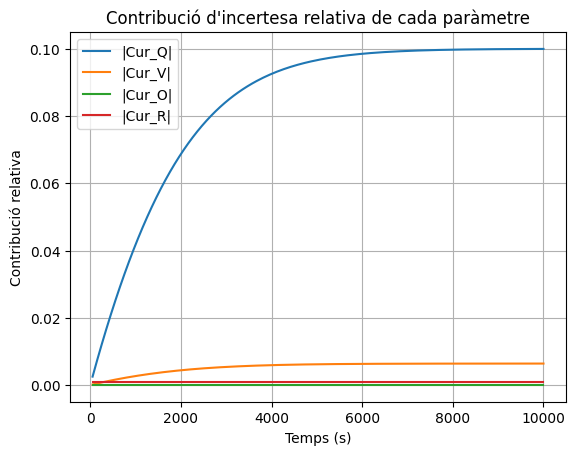

In [44]:
contribucio_parametres(Cur_Q, Cur_V, Cur_O, Cur_R_new)

Nova incertesa relativa total: 0.015514498982467977
Antiga incertesa relativa total: 0.1415651781995735


<IPython.core.display.Math object>

<lambdifygenerated-24>:2: RuntimeWarning: invalid value encountered in divide
  return sqrt(2.5e-11*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 7.3046018991965e-26*(209.476 - 209.476*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 4.06991089438836e-5*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2 + 1.0e-12*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))**2/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))**2)


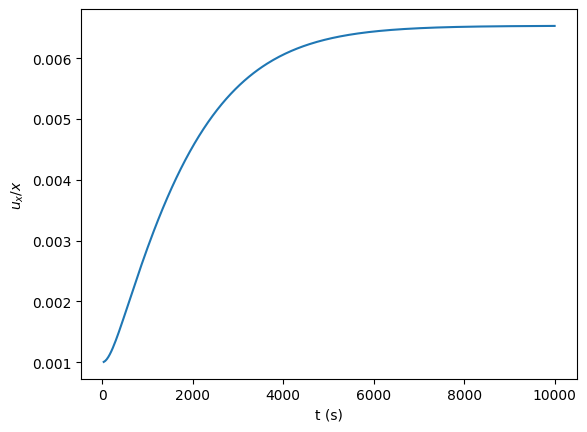

In [46]:
# reduim la incertesa de R entre 10 (s'ha provat entre 2 i 4 i se seguia superant el límit)
reduir = 10

Q_unc_new = Q_unc / reduir
Q_rel_unc_new = Q_unc_new / Q_val

# Recalculem la incertesa relativa total
incertesa_relativa_total_new = np.sqrt(R_rel_unc_new**2 + O_rel_unc**2 + V_rel_unc**2 + Q_rel_unc_new**2)
print(f"Nova incertesa relativa total: {incertesa_relativa_total_new}")
print(f"Antiga incertesa relativa total: {Total_rel_unc}")

Cur_Q_new = Cur_Q * Q_rel_unc_new

urXt2 = Cur_Q_new**2 + Cur_V**2 + Cur_O**2 + Cur_R_new**2
show("urXt^2_C=", urXt2)
times = np.linspace(0, 10000, 300) #data['t (s)']
furC = sp.lambdify(t, sp.sqrt(urXt2).subs(valors))

urc = furC(times)

plt.plot(times, urc)
# plt.hlines(0.02, color='red', label='Uncertainty Threshold', xmin=0, xmax=1000)
plt.xlabel('t (s)')
plt.ylabel('$u_x/x$')
plt.show()


<lambdifygenerated-25>:2: RuntimeWarning: invalid value encountered in divide
  return 1.0e-6*(5.66151351351351e-8*t*exp(-0.001*t) - 5.66151351351351e-5 + 5.66151351351351e-5*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-26>:2: RuntimeWarning: invalid value encountered in divide
  return 0.00637958532695375*(-5.66151351351351e-11*t*exp(-0.001*t) + 5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-27>:2: RuntimeWarning: invalid value encountered in divide
  return 5.0e-6*(2.7027027027027e-7 - 2.7027027027027e-7*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))
<lambdifygenerated-28>:2: RuntimeWarning: invalid value encountered in divide
  return 2.7027027027027e-13*(209.476 - 209.476*exp(-0.001*t))/(5.66151351351351e-8 - 5.66151351351351e-8*exp(-0.001*t))


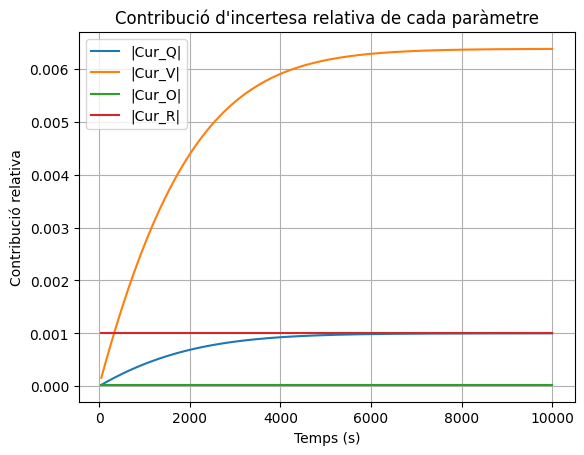

In [47]:
contribucio_parametres(Cur_Q_new, Cur_V, Cur_O, Cur_R_new)

In [50]:
def ajustar_incerteses(Q_u, V_u, O_u, R_u, umbral=0.01, max_iter=100): 
    times = np.linspace(1, 10000, 300) #data['t (s)']
    for i in range(max_iter):
        Q_r, V_r, O_r, R_r = Q_u/Q_val, V_u/V_val, O_u/O_val, R_u/R_val
        # Expressions simbòliques 
        Cur_Q = (Coef_Q * Q_r)**2
        Cur_V = (Coef_V * V_r)**2
        Cur_O = (Coef_O * O_r)**2
        Cur_R = (Coef_R * R_r)**2
        
        # Lambdify per poder evaluar-les en temps
        f_Q = sp.lambdify(t, Cur_Q.subs(valors))
        f_V = sp.lambdify(t, Cur_V.subs(valors))
        f_O = sp.lambdify(t, Cur_O.subs(valors))
        f_R = sp.lambdify(t, Cur_R.subs(valors))

        q_vals, v_vals, o_vals, r_vals = f_Q(times), f_V(times), f_O(times), f_R(times)
        urc_vals = np.sqrt(q_vals + v_vals + o_vals + r_vals)

        if np.max(urc_vals) <= umbral:
            break

        # Identifiquem el paràmetre que aporta més incertesa màxima
        contribucions = {
            'Q': np.max(q_vals),
            'V': np.max(v_vals),
            'O': np.max(o_vals),
            'R': np.max(r_vals)
        }
        pitjor = max(contribucions, key=contribucions.get)

        print(f"Iteració {i+1}: Ajustant {pitjor} per reduir la incertesa màxima")
        if pitjor == 'Q': Q_u /= 2
        elif pitjor == 'V': V_u /= 2
        elif pitjor == 'O': O_u /= 2
        elif pitjor == 'R': R_u /= 2

    return Q_u, V_u, O_u, R_u

In [51]:
print(ajustar_incerteses(Q_unc, V_unc, O_unc, R_unc))

Iteració 1: Ajustant R per reduir la incertesa màxima
Iteració 2: Ajustant Q per reduir la incertesa màxima
Iteració 3: Ajustant R per reduir la incertesa màxima
Iteració 4: Ajustant Q per reduir la incertesa màxima
Iteració 5: Ajustant R per reduir la incertesa màxima
Iteració 6: Ajustant Q per reduir la incertesa màxima
Iteració 7: Ajustant R per reduir la incertesa màxima
Iteració 8: Ajustant Q per reduir la incertesa màxima
Iteració 9: Ajustant V per reduir la incertesa màxima
(6.25e-06, 0.4, 5e-06, 1.6891891891891894e-12)


### Exercici 2

Tenim un taller en el qual hi ha 5 màquines idèntiques que processen tasques que arriben de forma aleatòria cada 12 minuts de mitjana.
Les tasques s’assignen a qualsevol màquina que estigui lliure, o fan cua esperant que hi hagi alguna màquina lliure.
El temps necessari per completar una tasca també és aleatori, però de mitjana es triga una hora per a totes les tasques i màquines.

Al taller hi treballen 3 operaris, que tenen dues feines principals:

- Preparar les màquines perquè inicien la tasca que ha arribat.

- Reparar una màquina que ha fallat.

La preparació de la tasca necessita un temps aleatori, però que de mitjana és de 20 minuts.
La reparació necessita dos operaris i un temps aleatori, que de mitjana és de mitja hora.
Quan ha finalitzat una tasca, el 20% dels cops cal reparar la màquina.

- Fes 10 simulacions d'una setmana i calcula la llargària mitjana de la cua de tasques.

- Què faries per reduir la cua de tasques i per què?


**SOLUCIÓ HELENA**

In [2]:
def reparacio(env, maquina, tecnic, log):
    """
    Reparació d'una màquina
        - la reparació necessita 2 operaris i un temps aleatori (mean=30)
        - el 20 % dels cops cal reparar una maquina
    """
    with tecnic.request() as t1, tecnic.request() as t2:
        yield t1 & t2

        temps_rep = np.random.exponential(1/30)
        yield env.timeout(temps_rep)

In [ ]:
def processar(env, maquina, tecnic, log):
    """
    Processar una tasca
        - la tasca necessita 1 màquina (ja bloquejada) i un temps aleatori (mean=60)
    """

    temps_proc = np.random.exponential(1/60)
    yield env.timeout(temps_proc)

    # reparació màquina amb tecnic -- màquina encara no està alliberada
    if np.random.binomial(1, 0.2):
        yield env.process(reparacio(env, maquina, tecnic, log))

    log.append(len(maquina.queue))

In [ ]:
def preparacio(env, maquina, tecnic, log):
    """
    Preparació d'una màquina
        - la preparació d'una maquina necessita 1 operari i un temps aleatori (mean=20)
    """
    with maquina.request() as m1:
        yield m1
        with tecnic.request() as t1:
            yield t1

            temps_rep = np.random.exponential(1/20)
            yield env.timeout(temps_rep)
            # alliberem el tècnic
        
        # processem la tasca
        yield env.process(processar(env, maquina, tecnic, log))

In [5]:
def arribades(env, maquina, tecnic, log):
    """
    Procés d'arribades
    """
    while True:
        temps = np.random.exponential(1/12)
        yield env.timeout(temps)

        env.process(preparacio(env, maquina, tecnic, log))

Mitjana de tasques en cua: 0.0071993107219193745


(array([1.20034e+05, 0.00000e+00, 5.09000e+02, 0.00000e+00, 0.00000e+00,
        1.32000e+02, 0.00000e+00, 2.80000e+01, 0.00000e+00, 3.00000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

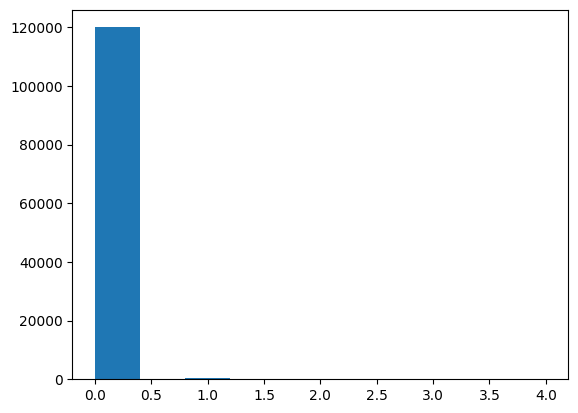

In [6]:
#log = pd.DataFrame(columns=['xxx'])
log1 = []
env = simpy.Environment()

maquina = simpy.Resource(env, capacity=5)
tecnic = simpy.Resource(env, capacity=3)

env.process(arribades(env, maquina, tecnic, log1))
env.run(until=7*24*60) # 7 dies en minuts 

print(f"Mitjana de tasques en cua: {np.mean(log1)}")
# Fer un histograma de la cua
plt.hist(log1)

Recursos:
- Màquines x5
- Tècnics x3

Processos:
- Processar tasca
    - sí trencat
    - no trencat
- Arribada
- Reparació
- Carregar

Relacions:
- Arr -> Carr -> Process
    - Process -> Carr
    - Process -> Reparar -> Carr
    
Demanen: Llarg Cua
Tenim Log (pd) on anem guardant la llargària de la cua



In [5]:
np.random.exponential?

El [chat](https://chatgpt.com/c/68435c54-5ca0-8006-932e-050678d3fa0a) sap coses:
- Definim processos com funcions amb statements `yield`. SimPy va a través d'aquests pel temps

En cada `yield`:
- **Pausa** el procés
- Espera **passi** cert esdeveniment
- Quan passa, continua a partir d'allà

Els **recursos** es comparteixen entre tot l'entorn:
- **Definim** amb: `resource = simpy.Resource(env, capacity=CAPACITY)`
-  Podem **demanar** el recurs amb `with resource.request() as req`
-  El procés s'**allibera** automàticament quan sortim del **bloc** `with`
   -  **COMPTE**: A vegades no ho sembla/ sembla que ho alliberem però s'ha cridat una **coupled function**... difícil traçar execució

A tenir en compte pels diferents processos:
- `yield env.timeout(...)`: Pausa el procés fins al **temps simulat** avança al desitjat (`...`)
- `env.process(...)`: Crea un **nou SimPy process** (corrutina) $\to$ permet correr en **paralel**
  - A arribades no va acompanyat de `yield` perquè continuen arribant de forma contínua
  - A la resta de procesos sí, perquè per a donar per "acabat" cert procés han d'acabar els de dins
- Combinació:
    ```
    with resource.request() as r:
        yield r
    ```
    - Crea la **request** i pausa el procés fins que aquest estigui disponible

Per a tenir control dels esdeveniments, tenim:
- `len(resource.queue)` ens retorna quants processos estan esperant
- fem `log.append(len(resource.queue))` en cert punt estratègic per a analitzar l'estat de la cua en aquell punt

### Exercici 3

Analitza la següent cadena de Markov:
[<center><img src=https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/notebooks/static/markov.png width=25%></center>](#bib_Konstantopoulos)

- Escriu la matriu de transició
- És irreductible?
- És aperiòdica?
- Si comencem a l'estat 1, quina probabilitat n'hi ha que ens trobem a cada un dels estats deprés de 3 passes?
- Troba la distribució d'estats estable si existeix.

In [53]:
P = np.array([
    [1/2, 1/3, 1/6],
    [3/4, 0,   1/4],
    [0,   1,   0]
])
print(P)

## És irreductible ---> podem anar de qualsevol estat a qualsevol estat (camí, no aresta)
## Aperiòdica ---> puc anar tan parell com senar d'un estat a ell mateix

## Estat inicial:
estat0 = np.array([1, 0, 0])

## Estat estable quan x_e*P = x_e (trobar solució) només si és aperiòdica i irreductible

[[0.5        0.33333333 0.16666667]
 [0.75       0.         0.25      ]
 [0.         1.         0.        ]]


In [60]:
estat1 = estat0 @ P
estat1

array([0.5       , 0.33333333, 0.16666667])

In [57]:
estat2 = np.dot(estat1, P)
estat2

array([0.5       , 0.33333333, 0.16666667])

In [59]:
# np.linalg.solve(M, X)
# L'estat estacionari és el vector propi associat a l'autovalor 1

L = np.zeros((3, 3))
L[-1] = np.ones(3) # Última fila de L sigui 1
I = np.eye(3) # Identaiat

M = P.T - I # Matriu 3 transposada menys identitat
M[-1] = np.ones(3) # forcem que la suma sigui 1

X = np.zeros((3))
X[-1] = 1 # Vecotr de resultats amb única condició suma = 1

# Calculem estat estacionari
pi = np.linalg.solve(M, X)
print("Estat estacionari:", pi)

Estat estacionari: [0.5        0.33333333 0.16666667]


# Referències

- <a id='img_FaXToR'></a> Takis Konstantopoulos, **2019**. *Stochastic Processes I*

Copyright (C) 2022 Gabriel Jover Mañas

    Permission is granted to copy, distribute and/or modify this document
    under the terms of the GNU Free Documentation License, Version 1.3
    or any later version published by the Free Software Foundation;
    with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.
    A copy of the license is included in the section entitled "GNU
    Free Documentation License".

![GFDL][GFDL]

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

![GPL3][GPL3]

[GFDL]: static/gfdl-logo-small.png
[GPL3]: static/gplv3-127x51.png